# DEA Coastlines vector statistics <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts vector subpixel shoreline extraction for DEA Coastlines:

* Apply morphological extraction algorithms to mask annual median composite rasters to a valid coastal region
* Extract waterline vectors using subpixel waterline extraction ([Bishop-Taylor et al. 2019b](https://doi.org/10.3390/rs11242984))
* Compute rates of coastal change at every 30 m along Australia's non-rocky coastlines using linear regression

This is an interactive version of the code intended for prototyping; to run this analysis at scale, run `dea_coastlines.vector.py`.


---

In [ ]:
pip install -r ../requirements.txt

### Load packages

First we import all required Python packages, and then start the vector coastline extraction process.

In [1]:
cd ..

/home/jovyan/Robbi/dea-coastlines


In [2]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.transform import array_bounds
from dea_tools.spatial import subpixel_contours

# Load DEA Coastlines code
import dea_coastlines.raster
import dea_coastlines.vector

# Hide Pandas warnings
pd.options.mode.chained_assignment = None


## Load in data

In [3]:
study_area = 39
raster_version = 'testing'
vector_version = 'testing'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2020'

# Load analysis params from config file
config = dea_coastlines.raster.load_config(
    config_path='configs/deafrica_coastlines_config.yaml')

## Load DEA Coastlines rasters

In [4]:
yearly_ds, gapfill_ds = dea_coastlines.vector.load_rasters(
    path='data/interim/raster',
    raster_version=raster_version,
    study_area=study_area,
    water_index=water_index,
    start_year=2000)
print(yearly_ds)

# Create output vector folder
output_dir = f'data/interim/vector/{vector_version}/{study_area}_{vector_version}'
os.makedirs(output_dir, exist_ok=True)

<xarray.Dataset>
Dimensions:  (year: 21, y: 1339, x: 1562)
Coordinates:
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019 2020
  * y        (y) float64 1.645e+06 1.645e+06 1.645e+06 ... 1.605e+06 1.605e+06
  * x        (x) float64 2.001e+05 2.001e+05 2.001e+05 ... 2.469e+05 2.469e+05
Data variables:
    mndwi    (year, y, x) float32 0.2687 0.2567 0.264 ... 0.1281 0.1301 0.09406
    tide_m   (year, y, x) float32 -0.118 -0.118 -0.118 ... -0.1256 -0.1256
    temp     (year, y, x) float32 21.65 21.65 21.66 21.5 ... 21.0 20.9 21.07
    count    (year, y, x) int16 4 4 4 4 4 4 4 4 4 ... 29 29 29 29 29 29 28 27 26
    stdev    (year, y, x) float32 0.05281 0.06972 0.1119 ... 0.2894 0.3177
Attributes:
    transform:      | 30.00, 0.00, 200055.00|\n| 0.00,-30.00, 1645005.00|\n| ...
    crs:            +init=epsg:32628
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  

## Load vector data

In [5]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Tide points
tide_points_gdf = (gpd.read_file(config['Input files']['coastal_points_path'],
                                 bbox=bbox).to_crs(yearly_ds.crs))

# Study area polygon
gridcell_gdf = (gpd.read_file(config['Input files']['coastal_grid_path'],
                              bbox=bbox).set_index('id').to_crs(
                                  str(yearly_ds.crs)))
gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# Load climate indices
climate_df = dea_coastlines.vector.load_climate_data(
    index='soi',
    years=(yearly_ds.year.min().item(), yearly_ds.year.max().item()),
    annual=True,
    detrend=True)

## Extract shoreline contours

### Extract ocean-masked contours

In [67]:
# If a waterbody mask is provided, use this to remove non-coastal
# waterbodies and estuaries from the dataset. If not, use empty mask
if config['Input files']['waterbody_mask_path']:

    # Generate waterbody mask
    print('Generating waterbody mask')
    waterbody_mask = dea_coastlines.vector.waterbody_masking(
        input_data=config['Input files']['waterbody_mask_path'],
        modification_data=config['Input files']['waterbody_modifications_path'],
        bbox=bbox,
        yearly_ds=yearly_ds)
    
else:
    waterbody_mask = np.full(yearly_ds.geobox.shape, False, dtype=bool)
    

In [73]:
# Mask dataset to focus on coastal zone only
masked_ds = dea_coastlines.vector.contours_preprocess(
    yearly_ds,
    gapfill_ds,
    water_index,
    index_threshold,
    waterbody_mask,
    tide_points_gdf,
    output_path=output_dir,
    buffer_pixels=30)

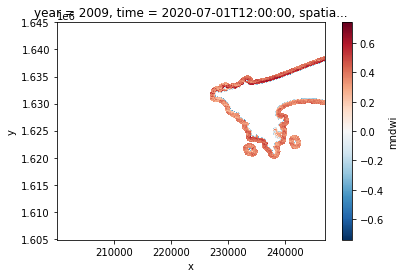

In [75]:
masked_ds.isel(year=9).plot.imshow()

In [76]:
# Extract contours
contours_gdf = (subpixel_contours(da=masked_ds,
                                  z_values=index_threshold,
                                  min_vertices=10,
                                  dim='year',
                                  output_path=f'temp.geojson')
                .set_index('year'))


## Compute statistics
### Create stats points on baseline contour

In [ ]:
# Extract statistics modelling points along baseline contour
points_gdf = dea_coastlines.vector.points_on_line(contours_gdf,
                                                  baseline_year,
                                                  distance=30)

# If a rocky mask is provided, use this to clip data
if config['Input files']['coastal_classification_path']:

    # Import coastline classification
    print('Clipping to non-rocky shorelines')
    coastal_classification_gdf = (gpd.read_file(
        config['Input files']['coastal_classification_path'],
        bbox=bbox).to_crs(yearly_ds.crs))

    # Clip to remove rocky shoreline points
    points_gdf = dea_coastlines.vector.rocky_shores_clip(
        points_gdf, coastal_classification_gdf, buffer=50)

### Measure annual coastline movements

In [ ]:
if points_gdf is not None:  

    # Calculate annual movements and residual tide heights for every 
    # contour compared to the baseline year
    points_gdf = dea_coastlines.vector.annual_movements(points_gdf,
                                              contours_gdf,
                                              yearly_ds,                                     
                                              baseline_year,
                                              water_index)

### Calculate regressions

In [ ]:
if points_gdf is not None:

    # Apply regression function to each row in dataset
    points_gdf = dea_coastlines.vector.calculate_regressions(points_gdf,
                                                   contours_gdf,
                                                   climate_df)

# Add count and span of valid obs, Shoreline Change Envelope (SCE), 
# Net Shoreline Movement (NSM) and Max/Min years
stats_list = ['valid_obs', 'valid_span', 'sce', 'nsm', 'max_year', 'min_year']
points_gdf[stats_list] = points_gdf.apply(
    lambda x: dea_coastlines.vector.all_time_stats(x, 
                                                   initial_year=2000), axis=1)

## Export files

### Export stats files

In [ ]:
if points_gdf is not None:
    
    # Set up scheme to optimise file size
    schema_dict = {key: 'float:8.2' for key in points_gdf.columns
                   if key != 'geometry'}
    schema_dict.update({'sig_time': 'float:8.3',
                        'outl_time': 'str:80',
                        'sig_soi': 'float:8.3',
                        'outl_soi': 'str:80',
                        'valid_obs': 'int:4',
                        'valid_span': 'int:4',
                        'max_year': 'int:4',
                        'min_year': 'int:4',
                       })
    col_schema = schema_dict.items()

    # Clip stats to study area extent
    stats_path = f'{output_dir}/ratesofchange_{study_area}_' \
                 f'{vector_version}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(gridcell_gdf.geometry.item())]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    points_gdf.to_file(f'{stats_path}.shp',
                       schema={'properties': col_schema,
                               'geometry': 'Point'})

### Export contours

In [ ]:
# Assign certainty to contours based on underlying masks
contours_gdf = dea_coastlines.vector.contour_certainty(
    contours_gdf, 
    output_path=output_dir)

# Add maturity details
contours_gdf['maturity'] = 'final'
contours_gdf.loc[contours_gdf.index == baseline_year, 'maturity'] = 'interim'

# Clip annual shoreline contours to study area extent
contour_path = f'{output_dir}/annualshorelines_{study_area}_{vector_version}_' \
               f'{water_index}_{index_threshold:.2f}'
contours_gdf['geometry'] = contours_gdf.intersection(gridcell_gdf.geometry.item())
contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
                                                       driver='GeoJSON')

# Export stats and contours as ESRI shapefiles
contours_gdf.reset_index().to_file(f'{contour_path}.shp')

## Add Geoserver fields

### Rate of change points


In [ ]:
# # stats_path = 'releases/DEACoastlines_v1.0.0/Shapefile/DEACoastlines_ratesofchange_v1.0.0.shp'
# stats_path = 'DEACoastlines_ratesofchange_v1.1.0.shp'
# points_gdf = gpd.read_file(stats_path)

In [ ]:
# # Add WMS-specific fields
# points_gdf['wms_valobs'] = points_gdf.valid_obs > 25
# points_gdf['wms_t_retr'] = points_gdf.rate_time < 0
# points_gdf['wms_t_grew'] = points_gdf.rate_time > 0
# points_gdf['wms_t_sig'] = points_gdf.sig_time <= 0.01
# points_gdf['wms_t_abs'] = points_gdf.rate_time.abs()
# points_gdf['wms_t_less'] = points_gdf.wms_t_abs < 0.31
# points_gdf['wms_t_conf'] = points_gdf.se_time * 1.96
# points_gdf['wms_s_sig'] = points_gdf.sig_soi <= 0.01
# points_gdf['wms_s_abs'] = points_gdf.rate_soi.abs()
# points_gdf['wms_s_conf'] = points_gdf.se_soi * 1.96
# points_gdf.head(10)

In [ ]:
# # Set up scheme to optimise file size
# schema_dict = {key: 'float:8.2' for key in points_gdf.columns
#                if key != 'geometry'}
# schema_dict.update({'sig_time': 'float:8.3',
#                     'outl_time': 'str:80',
#                     'sig_soi': 'float:8.3',
#                     'outl_soi': 'str:80',
#                     'valid_obs': 'int:4',
#                     'valid_span': 'int:4',
#                     'max_year': 'int:4',
#                     'min_year': 'int:4',
#                     'wms_valobs': 'bool',
#                     'wms_t_retr': 'bool', 
#                     'wms_t_grew': 'bool',
#                     'wms_t_sig': 'bool',
#                     'wms_s_sig': 'bool'
#                    })
# col_schema = schema_dict.items()

# # Export as ESRI shapefiles
# points_gdf.to_file('releases/DEACoastlines_v1.1.0/DEACoastlines_v1.1.0_geoserver/DEACoastlines_ratesofchange_v1.1.0_geoserver.shp',
#                    schema={'properties': col_schema, 'geometry': 'Point'})

### Annual coastlines

In [ ]:
# # contour_path = 'releases/DEACoastlines_v1.0.0/Shapefile/DEACoastlines_annualcoastlines_v1.0.0.shp'
# contour_path = 'DEACoastlines_annualshorelines_v1.1.0.shp'
# contours_gdf = gpd.read_file(contour_path)

In [ ]:
# # Add WMS-specific fields
# contours_gdf['wms_good'] = contours_gdf.certainty == 'good'
# contours_gdf['wms_tidal'] = contours_gdf.certainty == 'tidal issues'
# contours_gdf['wms_nodata'] = contours_gdf.certainty == 'insufficient data'
# contours_gdf['wms_aero'] = contours_gdf.certainty == 'aerosol issues'
# contours_gdf['wms_inter'] = contours_gdf.maturity == 'interim'
# contours_gdf.head()

In [ ]:
# # Set up scheme to optimise file size
# schema_dict = {key: 'str:30' for key in contours_gdf.columns
#                if key != 'geometry'}
# schema_dict.update({'wms_good': 'bool', 
#                     'wms_tidal': 'bool',
#                     'wms_nodata': 'bool',
#                     'wms_aero': 'bool',
#                     'wms_inter': 'bool'
#                    })
# col_schema = schema_dict.items()

# # Export as ESRI shapefiles
# contours_gdf.to_file('releases/DEACoastlines_v1.1.0/DEACoastlines_v1.1.0_geoserver/DEACoastlines_annualshorelines_v1.1.0_geoserver.shp',
#                      schema={'properties': col_schema, 'geometry': 'LineString'})

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** November 2021